# Fraud Detection using Unsupervised Learning
---
Taken from [Fraud Detection Handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html) and [Robin Teuwen's Kaggle notebook](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders)

Data taken from [Lopez-Rojas's Paysim dataset](https://www.kaggle.com/datasets/ealaxi/paysim1). **NEED TO DOWNLOAD HERE**

## Pre-Requisites

### Importing the Libraries

In [1]:
# Turning off Tensorflow loggings
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
# Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Importing TensorFlow and Keras Tuner
import tensorflow as tf
import keras_tuner as kt

# Importing the K-Means model
from sklearn.cluster import KMeans

# Importing the Gaussian Mixture model
from sklearn.mixture import GaussianMixture

# Importing data preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing metrics from Scikit-Learn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score, average_precision_score

### Setting up the Environment and Notebook

In [3]:
# Plot styling
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
# Pandas decimal precision
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# Setting some save paths
graph_path = "Graphs"
autoencoder_path = "Models//Autoencoder"
kmeans_path = "Models//K-Means"
gmm_path = "Models//GMM"

# Creating paths if they don't exist
for path in [graph_path, autoencoder_path, kmeans_path, gmm_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
# Checking if GPU is available
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("No GPU available")

No GPU available


### Importing the Dataset

In [7]:
# Importing the data in
trx = pd.read_csv("Dataset//PS_20174392719_1491204439457_log.csv")

# Renaming the columns
trx.rename(columns={"oldbalanceOrg": "oldBalanceOrig", "newbalanceOrig": "newBalanceOrig", 
                    "oldbalanceDest": "oldBalanceDest", "newbalanceDest": "newBalanceDest"}, inplace=True)

# Previewing the data
trx.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


## Data Exploration

### Data Dimension and Types

In [8]:
# Getting the dataset info
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
# Getting the shape of the data
trx.shape

(6362620, 11)

### Checking for Missing Values

In [10]:
# Checking for missing values
(trx.isnull().sum() != 0).sum()

0

### Descriptive Statistics

#### Summary Statistics

In [11]:
# Getting a description of the data
trx.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000
mean,243.397,179861.904,833883.104,855113.669,1100701.667,1224996.398,0.001,0.000
std,142.332,603858.231,2888242.673,2924048.503,3399180.113,3674128.942,0.036,0.002
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,156.000,13389.570,0.000,0.000,0.000,0.000,0.000,0.000
50%,239.000,74871.940,14208.000,0.000,132705.665,214661.440,0.000,0.000
75%,335.000,208721.478,107315.175,144258.410,943036.708,1111909.250,0.000,0.000
max,743.000,92445516.640,59585040.370,49585040.370,356015889.350,356179278.920,1.000,1.000


#### Frequency of Transactions by Type

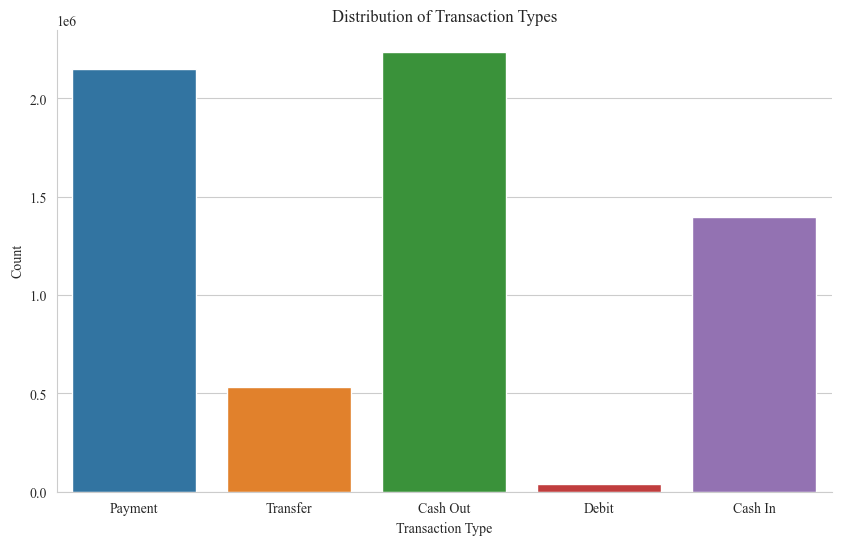

In [12]:
# Setting up the figure
plt.figure(figsize=(10, 6))

# Plotting the distribution of the transaction types
sns.countplot(x="type", data=trx)

# Plot settings
plt.title("Distribution of Transaction Types")
plt.xlabel("Transaction Type")
plt.xticks(np.arange(5),["Payment", "Transfer", "Cash Out", "Debit", "Cash In"])
plt.ylabel("Count")
sns.despine()

# Displaying the plot
plt.show()

#### Frequency of the Fraudulent Transactions

In [13]:
# Checking the distribution of the target variable
trx["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [14]:
# Ratio of non-fraud to fraud
trx["isFraud"].value_counts()[0]/ trx["isFraud"].value_counts()[1]

773.7010836478753

In [15]:
# Aggregating the data by the type of transaction
trx.groupby(["type", "isFraud"]).count()['step'].rename("count").to_frame()

count
type     isFraud         
CASH_IN  0        1399284
CASH_OUT 0        2233384
         1           4116
DEBIT    0          41432
PAYMENT  0        2151495
TRANSFER 0         528812
         1           4097

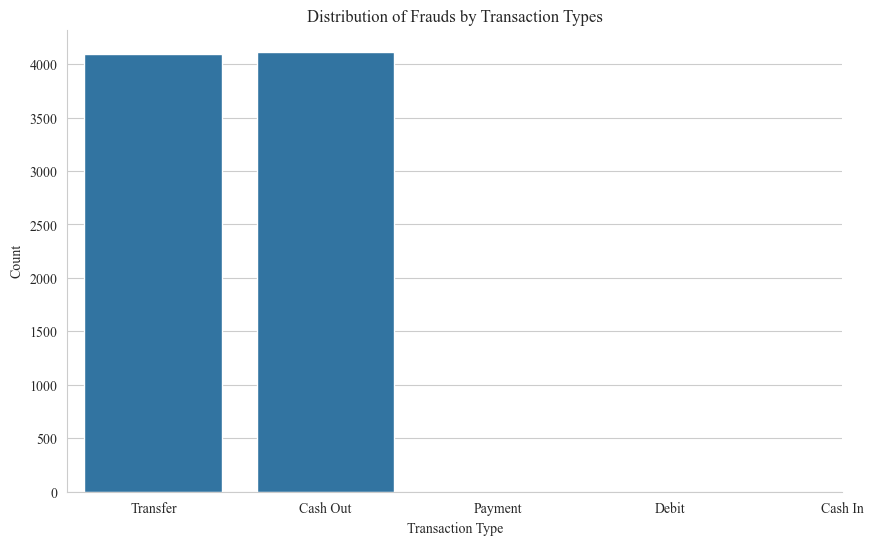

In [16]:
# Setting up the figure
plt.figure(figsize=(10, 6))

# Plotting the distribution of the transaction types
sns.countplot(x="type", hue="isFraud", data=trx.loc[trx.isFraud == 1])

# Plot settings
plt.title("Distribution of Frauds by Transaction Types")
plt.xlabel("Transaction Type")
plt.xticks(np.arange(5),["Transfer", "Cash Out", "Payment", "Debit", "Cash In"])
plt.ylabel("Count")
plt.legend([],[], frameon=False)
sns.despine()

# Displaying the plot
plt.show()

#### Distribution of Amounts aggregated by Fraudulent Transactions

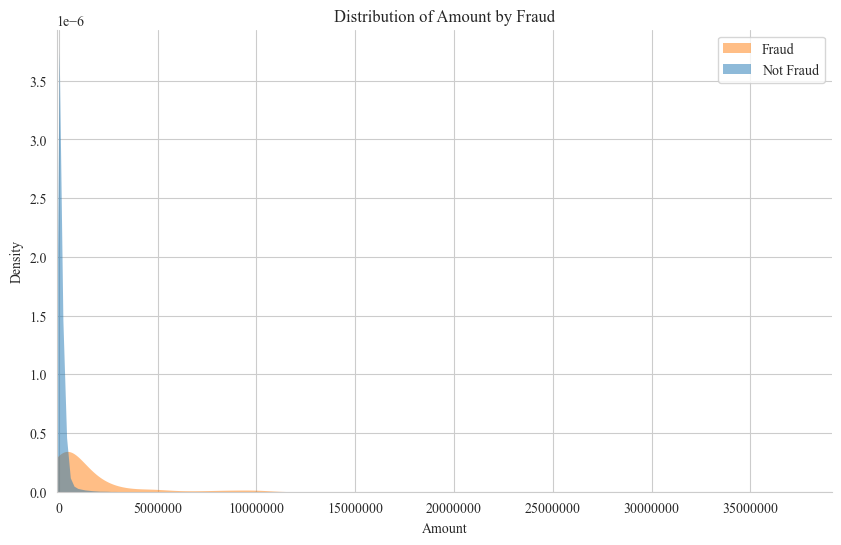

In [17]:
# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the distribution of amount grouped by fraud in a kde plot
sns.kdeplot(x="amount", data=trx.sample(100000, random_state=42), hue="isFraud", 
            fill=True, common_norm=False, alpha=.5, linewidth=0)

# Plot settings
plt.title("Distribution of Amount by Fraud")
plt.xlim(left=-100000)
plt.xlabel("Amount")
plt.ylabel("Density")
plt.ticklabel_format(style='plain', axis='x')
plt.legend(["Fraud", "Not Fraud"])
sns.despine()

# Displaying the plot
plt.show()

In [18]:
# Average transaction amount by type and fraud type
trx.groupby(["type", "isFraud"])['amount'].mean().rename("mean").to_frame()

mean
type     isFraud            
CASH_IN  0        168920.242
CASH_OUT 0        173917.156
         1       1455102.586
DEBIT    0          5483.665
PAYMENT  0         13057.605
TRANSFER 0        906229.008
         1       1480891.673

#### Frequency of Frauds by Time

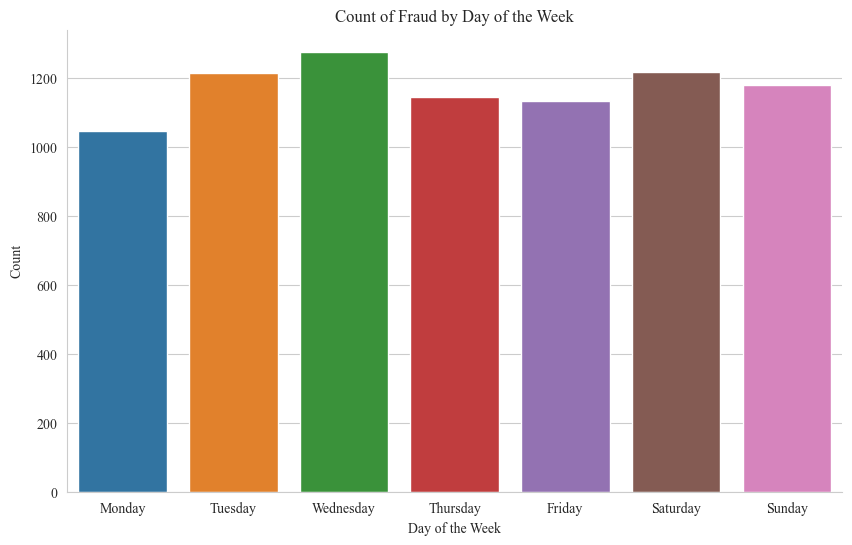

In [19]:
# Calculating the days of the week
day_of_week = trx.loc[trx.isFraud == 1, "step"] % 7

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the count of fraud by day of the week
sns.countplot(x=day_of_week)

# Plot settings
plt.title("Count of Fraud by Day of the Week")
plt.xlabel("Day of the Week")
plt.xticks(np.arange(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel("Count")
sns.despine()

# Displaying the plot
plt.show()

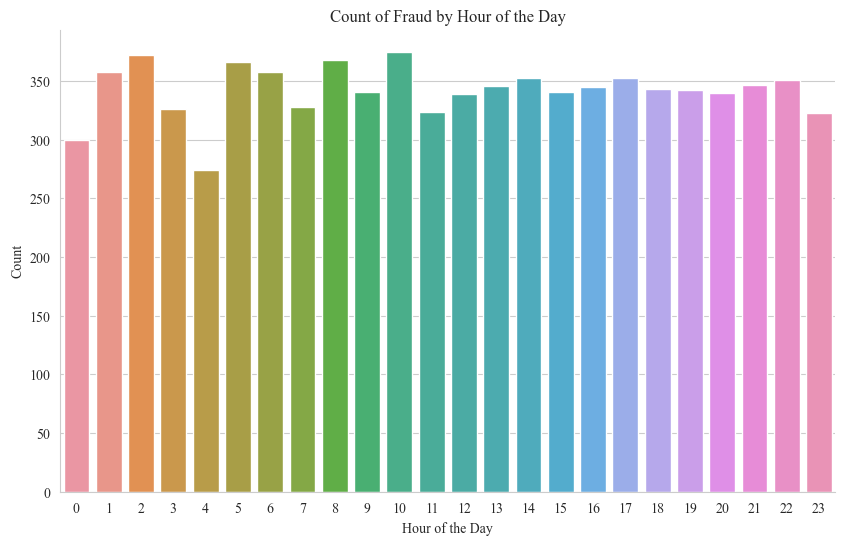

In [20]:
# Calculating the days of the week
hour_of_day = trx.loc[trx.isFraud == 1, "step"] % 24

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the count of fraud by day of the week
sns.countplot(x=hour_of_day)

# Plot settings
plt.title("Count of Fraud by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
sns.despine()

# Displaying the plot
plt.show()

#### Origin and Destination Frequency of Frauds

In [21]:
# Origin and destination pairs from the nameOrig and nameDest
orig_dest = trx["nameOrig"].apply(lambda x: x[0]) + trx["nameDest"].apply(lambda x: x[0])

# Converting the origin and destination pairs to text
orig_dest = orig_dest.replace({"CC": "Customer to Customer", "CM": "Customer to Merchant"})

# Checking the frequency of the origin and destination pairs
orig_dest.value_counts()

Customer to Customer    4211125
Customer to Merchant    2151495
dtype: int64

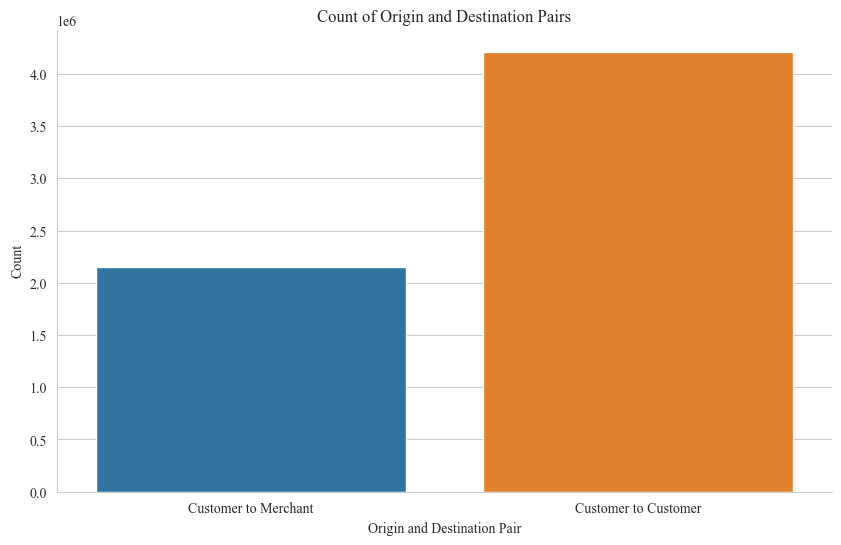

In [22]:
# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the count of origin and destination pairs
sns.countplot(x=orig_dest)

# Plot settings
plt.title("Count of Origin and Destination Pairs")
plt.xlabel("Origin and Destination Pair")
plt.ylabel("Count")
sns.despine()

# Displaying the plot
plt.show()

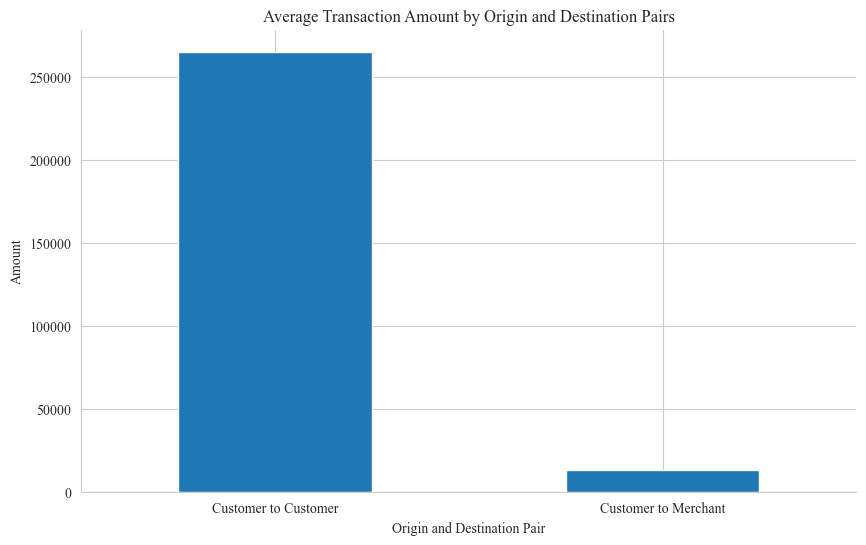

In [23]:
# Transaction amount by origin and destination pairs
trx.groupby(orig_dest)['amount'].mean().rename("mean").to_frame().plot(kind="bar", figsize=(10, 6))

# Plot settings
plt.legend([],[], frameon=False)
plt.title("Average Transaction Amount by Origin and Destination Pairs")
plt.xticks(rotation=0)
plt.xlabel("Origin and Destination Pair")
plt.ylabel("Amount")
plt.ticklabel_format(style='plain', axis='y')
sns.despine()

# Displaying the plot
plt.show()

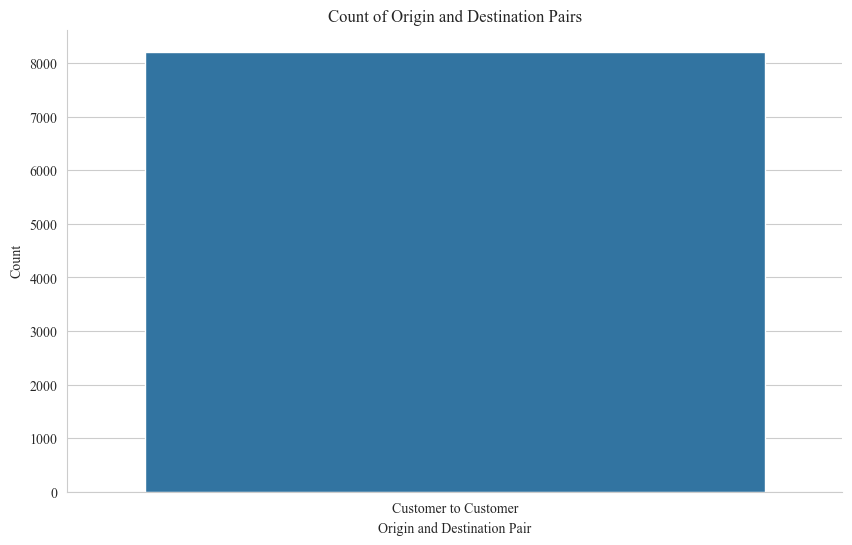

In [24]:
# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the count of origin and destination pairs
sns.countplot(x=orig_dest[trx.isFraud == 1])

# Plot settings
plt.title("Count of Origin and Destination Pairs")
plt.xlabel("Origin and Destination Pair")
plt.ylabel("Count")
sns.despine()

# Displaying the plot
plt.show()

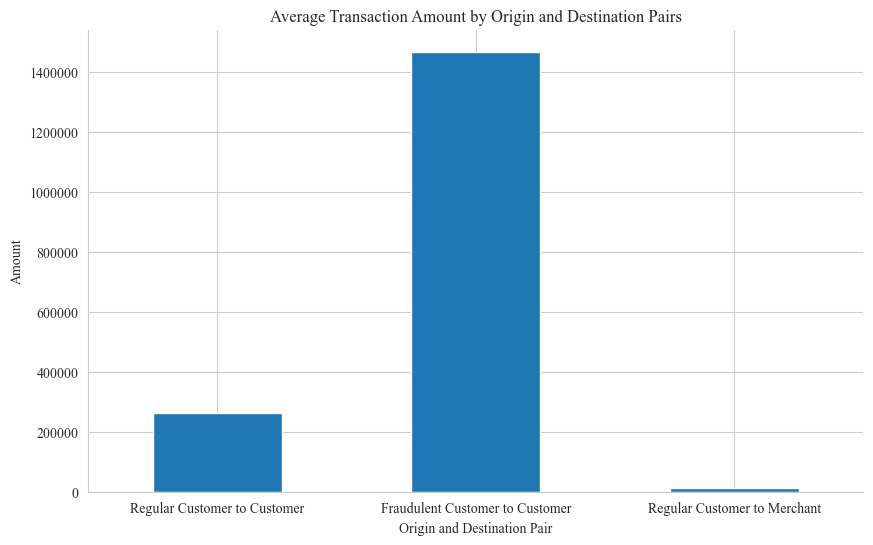

In [25]:
# Average transaction amount by origin and destination pairs
trx.groupby([orig_dest, trx.isFraud])["amount"].mean().rename("Mean").to_frame().plot(kind="bar", figsize=(10, 6))

# Plot settings
plt.legend([],[], frameon=False)
plt.title("Average Transaction Amount by Origin and Destination Pairs")
plt.xticks(np.arange(3), 
           ["Regular Customer to Customer", "Fraudulent Customer to Customer", "Regular Customer to Merchant", ], rotation=0)
plt.xlabel("Origin and Destination Pair")
plt.ylabel("Amount")
plt.ticklabel_format(style='plain', axis='y')
sns.despine()

# Displaying the plot
plt.show()

## Data Preprocessing

In [26]:
def clean_data(data):
    
    # Get the first letter of the nameOrig and nameDest columns
    data["nameOrig"] = data["nameOrig"].apply(lambda x: x[0])
    data["nameDest"] = data["nameDest"].apply(lambda x: x[0])

    # Concatenate the nameOrig and nameDest columns
    data["nameOrigDest"] = data["nameOrig"] + data["nameDest"]

    # Dropping the "nameOrig" and "nameDest" columns
    data.drop(["nameOrig", "nameDest"], axis=1, inplace=True)

    # Finding the change in balance for the origin and destination accounts
    data["origChange"] = data["newBalanceOrig"] - data["oldBalanceOrig"]
    data["destChange"] = data["newBalanceDest"] - data["oldBalanceDest"]

    # Modulo the step column by 24 to get the hour of the day
    data["hourOfDay"] = data["step"] % 24

    # Finding the day of the week
    data["day"] = data["step"] % 7

    # Mapping the day of the week to the actual day
    data["day"] = data["day"].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
                                   4: "Friday", 5: "Saturday", 6: "Sunday"})

    # Converting categorical types into one-hot encoding
    data = pd.concat([data, pd.get_dummies(data[["nameOrigDest", "type", "day"]], drop_first=True)], axis=1)

    # Dropping the redundant columns
    data.drop(["step", "newBalanceOrig", "newBalanceDest", "type", "isFlaggedFraud", "day", "nameOrigDest"], axis=1, inplace=True)

    return data

In [27]:
# Using the function to clean the data
data = clean_data(trx.copy())

# Fixing the column names
data.columns = data.columns.str.lower()
data.rename(columns={"isfraud": "is_fraud", "oldbalanceorig": "sender_balance_prev", "oldbalancedest": "receiver_balance_prev",
                     "origchange": "sender_balance_change", "destchange": "receiver_balance_change", 
                     "nameorigdest_cm": "cust_to_merchants", "hourofday": "hour_of_day"}, inplace=True)

In [28]:
# Separating the data into fraud and not fraud
fraud = data[data["is_fraud"] == 1]
not_fraud = data[data["is_fraud"] == 0]

In [29]:
# Selecting non-fraudulent transactions equal to the number of fraudulent transactions
X_test_not_fraud = not_fraud.sample(n=fraud.shape[0], random_state=42)

# Separating the remaining non-fraudulent transactions and the fraudulent transactions for the dev set
X_test = pd.concat([X_test_not_fraud, fraud], axis=0).sample(frac=1, random_state=42)
y_test = X_test["is_fraud"]
X_test = X_test.drop("is_fraud", axis=1)

# Getting only the non-fraudulent transactions for the training set and the dev set
X_train = not_fraud.drop(X_test_not_fraud.index)
y_train = X_train["is_fraud"]
X_train = X_train.drop("is_fraud", axis=1)

# Splitting the test data into test and dev sets
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [88]:
X_train.shape, X_test.shape, X_dev.shape

((6346194, 17), (8213, 17), (8213, 17))

In [30]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)

# Transforming the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_dev = scaler.transform(X_dev)

## Modelling the Data

### Helper Functions

In [31]:
def plot_roc_curve(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the FPR and TPR score at different thresholds
    fpr, tpr, thresholds = roc_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], label="Random Classifier")

    # Plot settings
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "roc_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=False)

    # Displaying the plot
    plt.show()

In [32]:
def plot_pr_threshold(label, prediction, title=None, xlim=(0, 100), save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the precision and recall for different thresholds
    plt.plot(thresholds, precision[1:], label="Precision")
    plt.plot(thresholds, recall[1:], label="Recall")

    # Plot settings
    plt.xlabel("Threshold")
    plt.xlim(xlim)
    plt.ylabel("Precision/Recall")
    plt.title("Precision/Recall to Threshold Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "prt_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=False)

    # Showing the plot
    plt.show()

In [33]:
def plot_precision_recall_curve(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the precision and recall for different thresholds
    precision, recall, _ = precision_recall_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the precision and recall for different thresholds
    plt.plot(recall, precision, label="Precision/Recall Curve")

    # Plot settings
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision/Recall Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "prc_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=False)

    # Showing the plot
    plt.show()

In [34]:
def plot_confusion_matrix(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Creating the confusion matrix
    cm = confusion_matrix(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # Plot settings
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for {}".format(title))

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "cm_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=False)

    # Showing the plot
    plt.show()
    

In [35]:
def plot_dist(non_fraud, fraud, bins, metric, title=None, save=False):

    # Setting up a couple of plot settings
    metric = metric if metric is not None else "Metric"
    title = title if title is not None else "the Model"

    # Setting up the plot
    plt.figure(figsize=(10, 6))

    # Plotting the histogram of distances
    sns.histplot(non_fraud, bins=bins, alpha=0.5, label='Not Fraud')
    sns.histplot(fraud, bins=bins, alpha=0.5, label='Fraud')

    # Plot settings
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {metric} for {title}")
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "dist_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=False)

    # Showing the plot
    plt.show()

In [36]:
def check_mean_std(raw_output, metric, verbose=True):
    
    # Calculating the mean and standard deviation of the raw output
    mean = np.mean(raw_output)
    std = np.std(raw_output)

    # Printing the mean and standard deviation if specified
    if verbose:
        print(f"Mean {metric}: {mean}")
        print(f"Standard Deviation {metric}: {std}")

    # Returning the mean and standard deviation
    return mean, std

In [37]:
def classifier_metrics(label, prediction, raw_prediction):
    
    # Accuracy score
    accuracy = accuracy_score(label, prediction)

    # F1 score
    f1 = f1_score(label, prediction)

    # Precision score
    precision = precision_score(label, prediction)

    # Recall score
    recall = recall_score(label, prediction)

    # AUROC score
    auroc = roc_auc_score(label, raw_prediction)

    # AUPRC score
    auprc = average_precision_score(label, raw_prediction)

    # Returning the scores
    return {"Accuracy": accuracy, "F1": f1, "Precision": precision, "Recall": recall, "AUROC": auroc, "AUPRC": auprc}

In [38]:
def load_or_retrain(filepath, model, X_train, model_args=None, retrain=False, tensorflow=False, save_model=True, log_path=None):
        
    # Checking if the model has already been trained
    if os.path.exists(filepath): print("File already exists")

    # Checking if the model is a tensorflow model
    if tensorflow:

        if not retrain:

            # Printing the status
            print("Loading the model...")

            # Loading the model
            model.load_weights(filepath)
        else:
            # Printing the status
            print("Training the model...")

            # Training the model
            history = model.fit(X_train, X_train, 
                                **model_args)

            # Saving the model if specified
            if save_model:
                # Saving the model's weight (weird how subclassing somehow doesn't save the model properly)
                model.save_weights(filepath, save_format="h5")

                # Printing the status
                print(f"Model trained and saved to {filepath}")

            # Saving the training history if specified
            if log_path is not None:
                joblib.dump(history.history, log_path)

                print(f"Training history saved to {log_path}")

    else:
        # Checking if the model has already been trained
        if not retrain:

            # Printing the status
            print("Loading the model...")

            # Loading the model
            model = joblib.load(filepath)

        # Training the model
        else:
            # Printing the status
            print("Training the model...")
            
            # Training the model
            model.fit(X_train)

            # Saving the model if specified
            if save_model:
                joblib.dump(model, filepath)

                # Printing the status
                print(f"Model trained and saved to {filepath}")
    
    # Returning the model
    return model

In [39]:
def tune_model_to(label, raw_prediction, thresholds=np.arange(0, 1), metric=f1_score):
    
        # Setting up the best score and best threshold
        best_score = 0
        best_threshold = 0
    
        # Looping through the thresholds
        for threshold in thresholds:
    
            # Converting the raw prediction to a binary prediction
            prediction = np.where(raw_prediction > threshold, 1, 0)
    
            # Calculating the score
            score = metric(label, prediction)
    
            # Checking if the score is better than the best score
            if score > best_score:
                best_score = score
                best_threshold = threshold
    
        # Returning the best threshold and best score
        return best_threshold, best_score

In [40]:
# Selecting random samples from the dataset
random_idx_lambda = lambda x, size: np.random.choice(x, size, replace=False)

# Selecting random samples from the dataset
X_train_sample = X_train[random_idx_lambda(X_train.shape[0], 50000)]

### K-Means Clustering

#### Calculating the Optimal Number of Clusters

In [41]:
def km_wcss(data, max_clust=5, random_state=42, n_init=5, max_iter=5, verbose=3):
    # Setting up the list of within-cluster sum of squares
    wcss = []

    # Looping through the number of clusters
    for i in range(1, max_clust + 1):
        # Fitting the KMeans model
        km = KMeans(n_clusters=i, random_state=random_state, n_init=n_init, max_iter=max_iter, verbose=verbose)
        km.fit(data)

        # Appending the within-cluster sum of squares to the list
        wcss.append(km.inertia_)

    return wcss

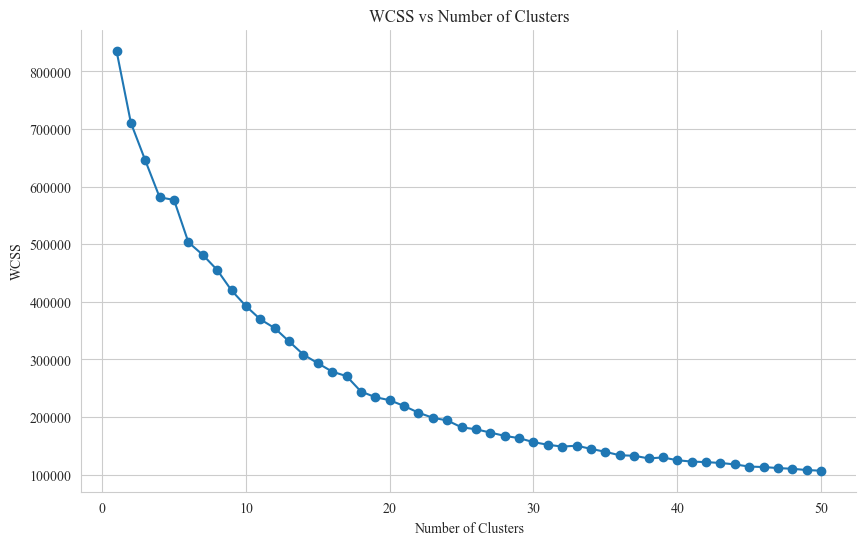

In [42]:
# Calculating the WCSS
if os.path.exists(os.path.join(kmeans_path, "wcss.pkl")):
    wcss = joblib.load(os.path.join(kmeans_path, "wcss.pkl"))
else:
    wcss = km_wcss(X_train_sample, max_clust=50, verbose=0)
    joblib.dump(wcss, os.path.join(kmeans_path, "wcss.pkl"))

# Plotting the WCSS
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), wcss, marker='o')

# Plot settings
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("WCSS vs Number of Clusters")
sns.despine()

# Showing the plot
plt.show()

#### Training the Model

In [43]:
# Creating the K-Means model
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10, max_iter=1000, verbose=3)

# Fitting the model
kmeans = load_or_retrain(filepath=os.path.join(kmeans_path, "kmeans.pkl"), model=kmeans, 
                         X_train=X_train, retrain=False, save_model=False)

File already exists
Loading the model...


#### Tuning the Model on the Dev Set

In [44]:
# Raw distance scores for the test set
km_distance_dev = kmeans.transform(X_dev).min(axis=1)

# Determining th threshold from the training set
km_threshold, _ = tune_model_to(label=y_dev, raw_prediction=km_distance_dev, thresholds=np.arange(0, 10, step=.01), metric=f1_score)

# Getting the predictions
km_pred_dev = (km_distance_dev  > km_threshold).astype(int)

In [45]:
# Evaluating the model
km_dev_eval = classifier_metrics(y_dev, km_pred_dev, km_distance_dev)

# Displaying the evaluation metrics
km_dev_eval

{'Accuracy': 0.8456106173140143,
 'F1': 0.8443407807512889,
 'Precision': 0.8512376237623762,
 'Recall': 0.837554797856795,
 'AUROC': 0.8900480106493719,
 'AUPRC': 0.9119916319212166}

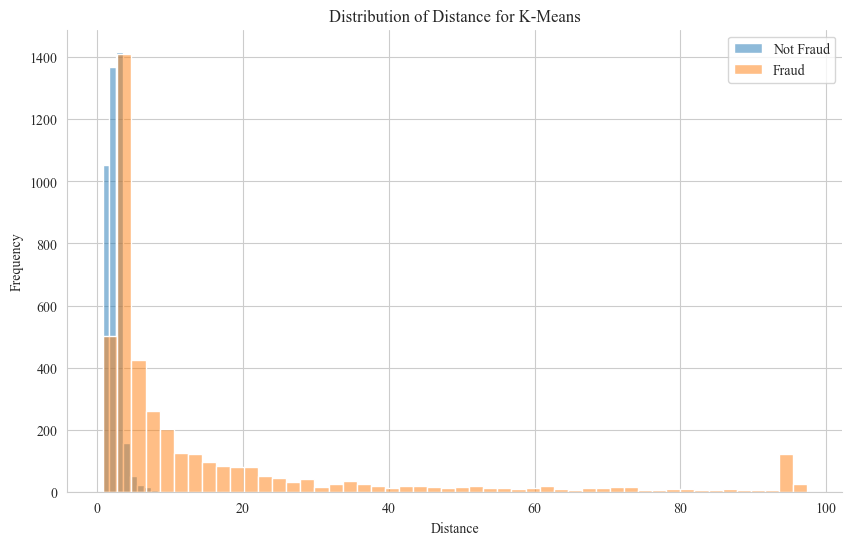

In [46]:
# Distribution of distances
plot_dist(km_distance_dev[y_dev == 0], km_distance_dev[y_dev == 1], 50, "Distance", "K-Means")

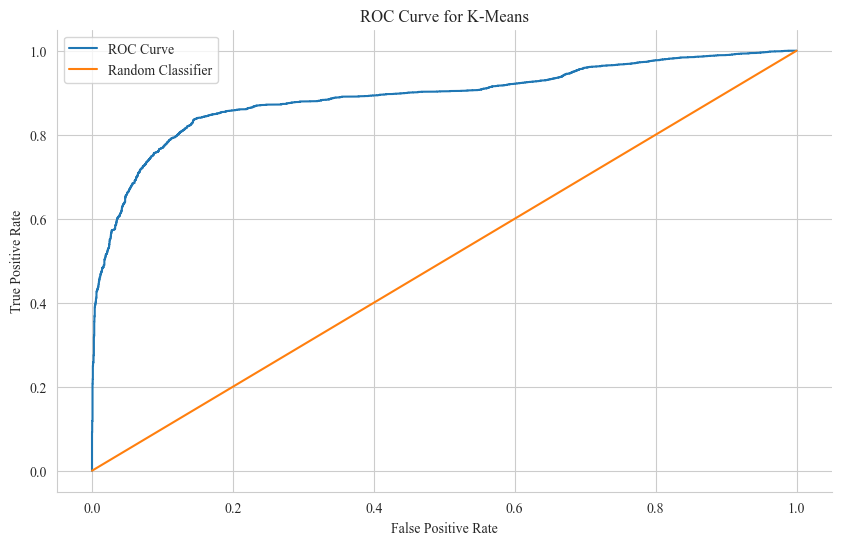

In [47]:
# Plotting the ROC curve
plot_roc_curve(y_dev, km_distance_dev , title="K-Means")

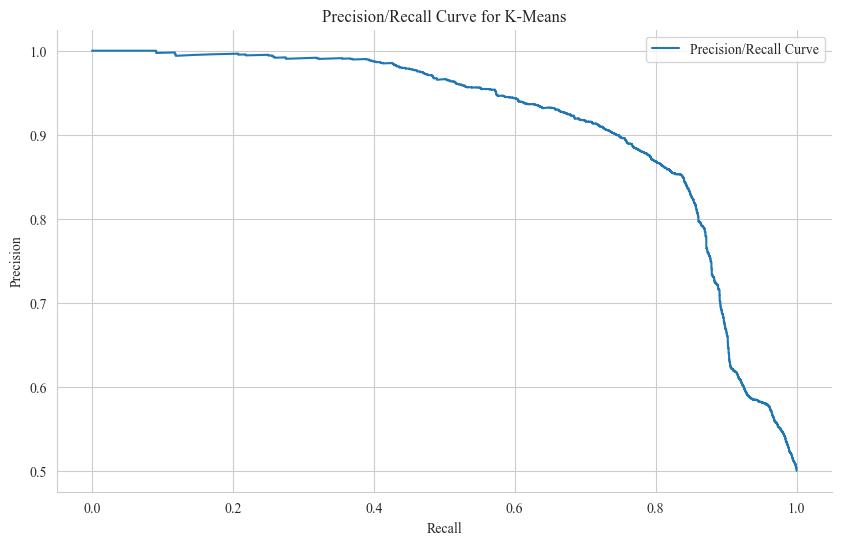

In [48]:
# Plotting the precision-recall curve
plot_precision_recall_curve(y_dev, km_distance_dev, title="K-Means")

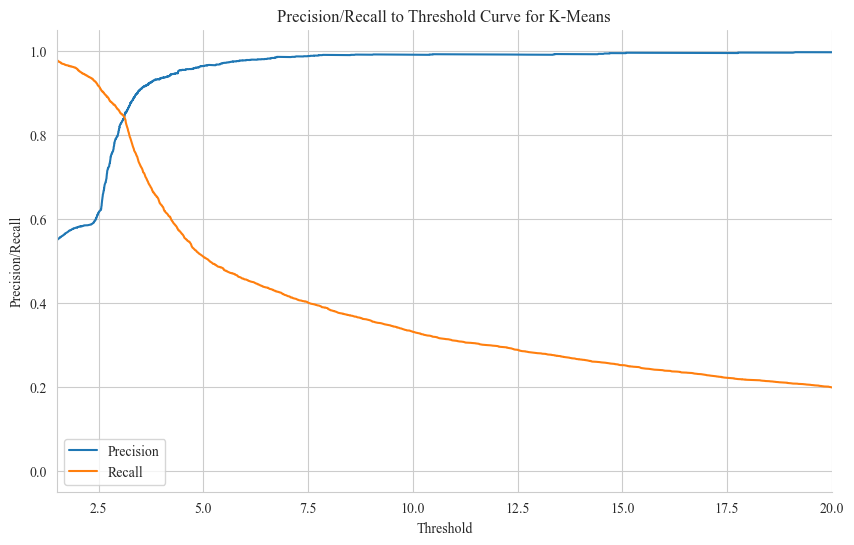

In [49]:
# Plotting the precision/recall to threshold curve
plot_pr_threshold(y_dev, km_distance_dev , title="K-Means", xlim=(1.5, 20))

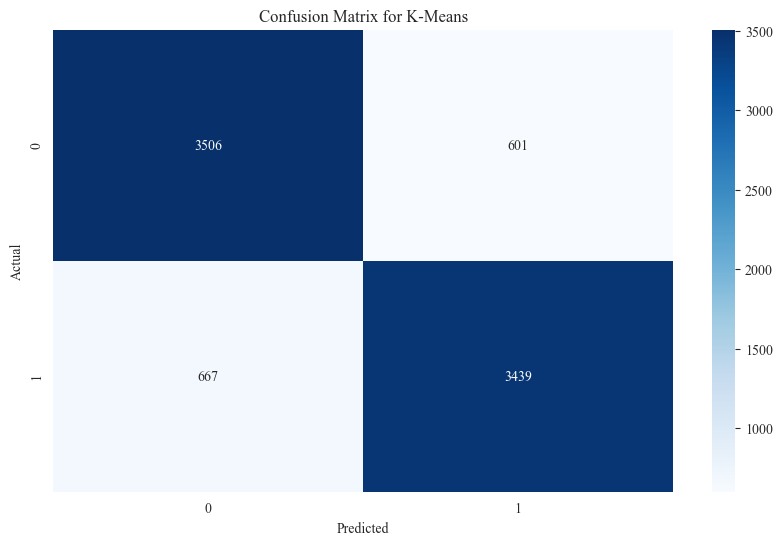

In [50]:
# Plotting the confusion matrix
plot_confusion_matrix(y_dev, km_pred_dev , title="K-Means")

### Gaussian Mixture

#### Calculating the Optimal Number of Clusters

In [51]:
def gm_bic(data, max_comp=5, random_state=42, verbose=3, n_init=5, max_iter=5):
    # Empty list for the BIC scores
    bic = []

    # Looping through the number of components
    for i in range(1, max_comp + 1):
        # Creating the Gaussian Mixture model
        gm = GaussianMixture(n_components=i, random_state=random_state, verbose=verbose, n_init=n_init, max_iter=max_iter)
        gm.fit(data)

        # Appending the BIC score
        bic.append(gm.bic(data))

    return bic

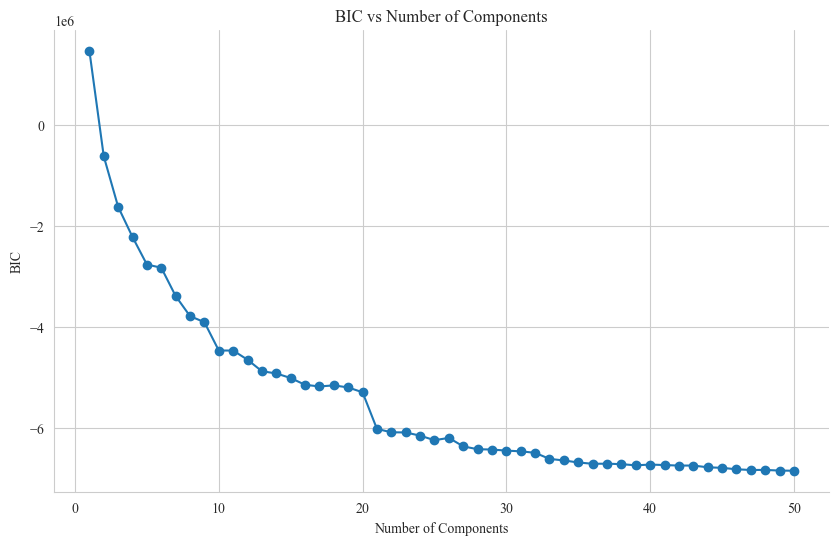

In [52]:
# Calculating the BIC
if os.path.exists(os.path.join(gmm_path, "bic.pkl")):
    bic = joblib.load(os.path.join(gmm_path, "bic.pkl"))
else:
    bic = gm_bic(X_train_sample, max_comp=50, verbose=5)
    joblib.dump(bic, os.path.join(gmm_path, "bic.pkl"))

# Plotting the BIC
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), bic, marker='o')

# Plot settings
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.title("BIC vs Number of Components")
sns.despine()

# Showing the plot
plt.show()

**Note**: If the component is greater than one, the downstream model performance deteriorate rapidly. Also the Gaussian Mixture model implementation isn't scalable to large datasets, hence slow or poor optimization may be observed. 

#### Training the Model

In [53]:
# Creating the Gaussian Mixture model
gmm = GaussianMixture(n_components=1, random_state=42, n_init=10, max_iter=1000, verbose=5)

# Fitting the model
gmm = load_or_retrain(filepath=os.path.join(gmm_path, "gmm.pkl"), model=gmm, 
                      X_train=X_train, retrain=False, save_model=False)

File already exists
Loading the model...


#### Tuning the Model on the Dev Set

In [54]:
# Raw density scores for the test set
gmm_density_dev = np.abs(gmm.score_samples(X_dev))

# Tuning the threshold
gmm_threshold, _ = tune_model_to(label=y_dev, raw_prediction=gmm_density_dev, thresholds=np.arange(0, 70, step=.1), metric=f1_score)

# Getting the predictions
gmm_pred_dev = (gmm_density_dev > gmm_threshold).astype(int)

In [55]:
# Evaluating the model
gmm_dev_eval = classifier_metrics(y_dev, gmm_pred_dev, gmm_density_dev)

# Displaying the evaluation metrics
gmm_dev_eval

{'Accuracy': 0.8515767685376842,
 'F1': 0.8509597750336227,
 'Precision': 0.85440707095507,
 'Recall': 0.847540185094983,
 'AUROC': 0.9073394229921922,
 'AUPRC': 0.9207331076857179}

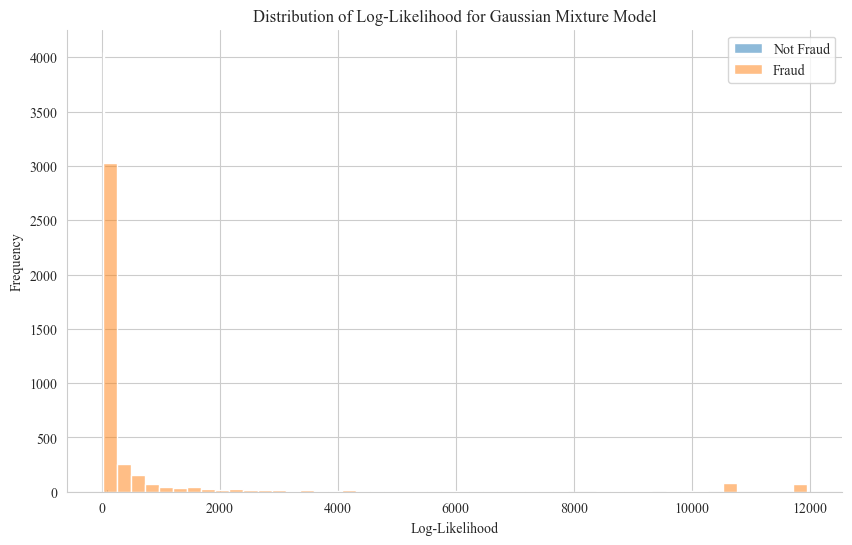

In [56]:
# Distribution of Log-Likelihood
plot_dist(gmm_density_dev[y_dev == 0], gmm_density_dev[y_dev == 1], 50, "Log-Likelihood", "Gaussian Mixture Model")

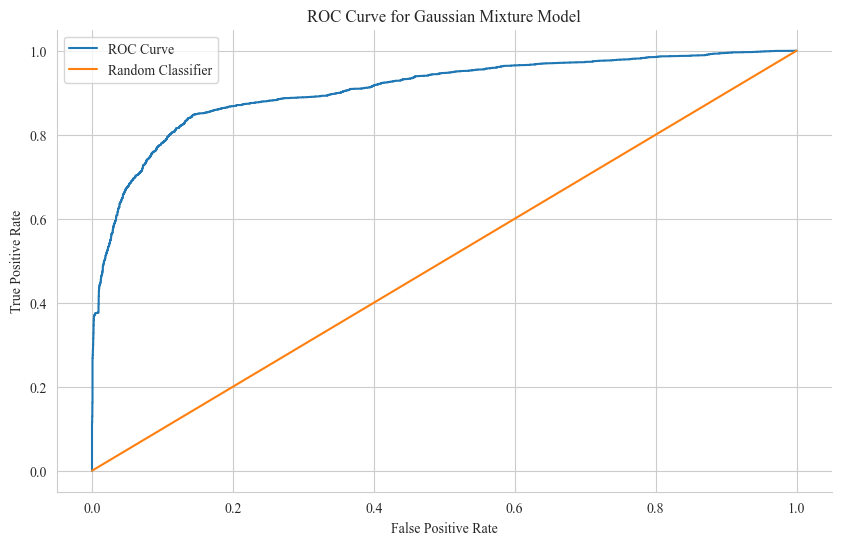

In [57]:
# Plotting the ROC curve
plot_roc_curve(y_dev, gmm_density_dev, title="Gaussian Mixture Model")

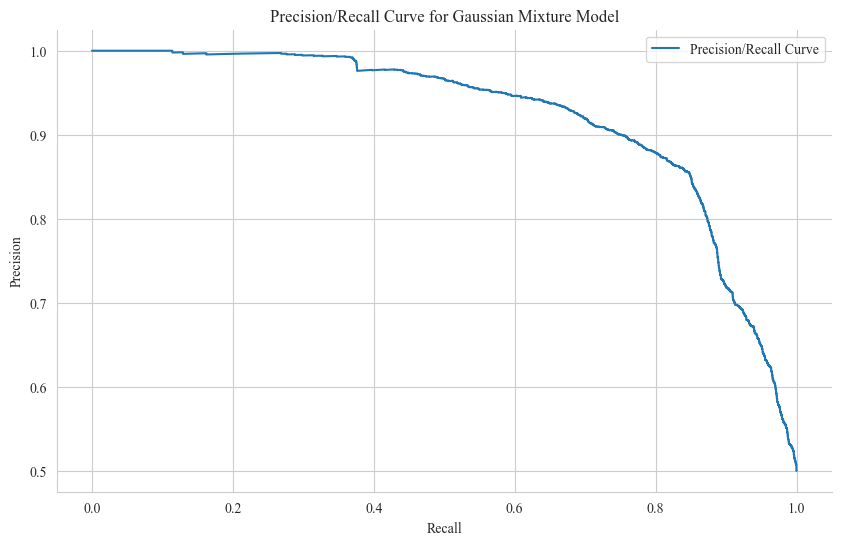

In [58]:
# Plotting the precision-recall curve
plot_precision_recall_curve(y_dev, gmm_density_dev, title="Gaussian Mixture Model")

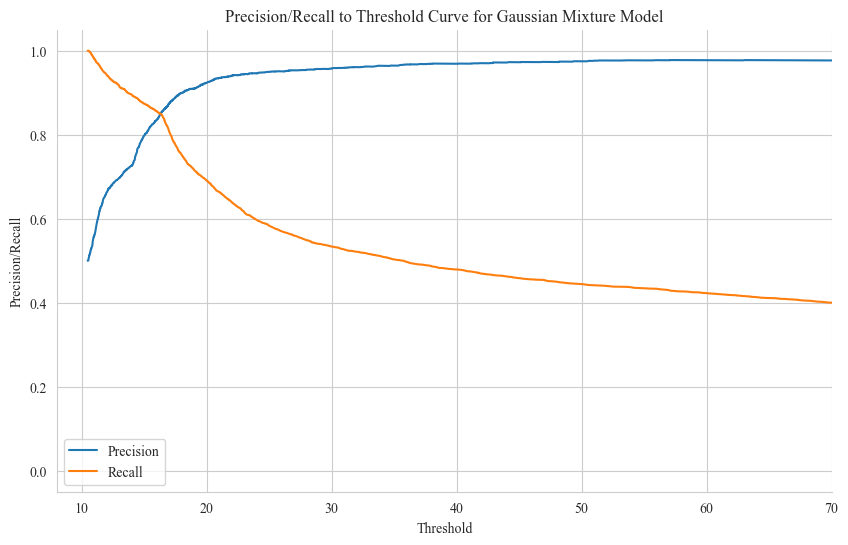

In [59]:
# Plotting the precision/recall to threshold curve
plot_pr_threshold(y_dev, gmm_density_dev, title="Gaussian Mixture Model", xlim=(8, 70))

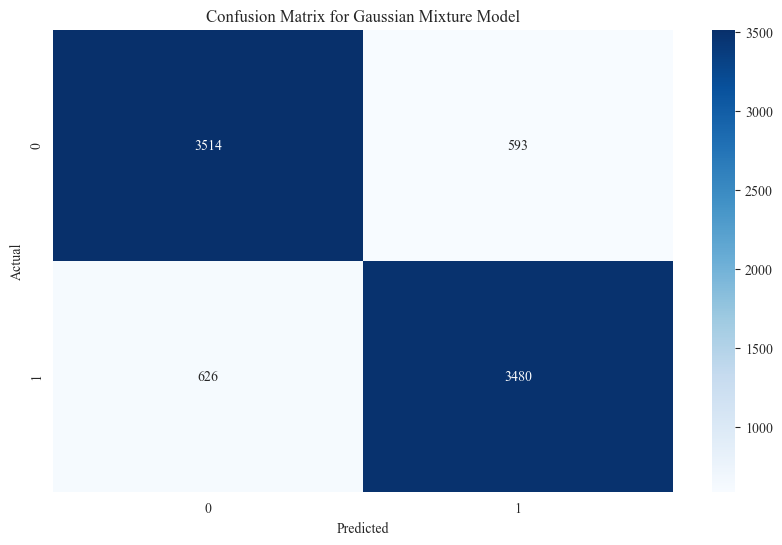

In [60]:
# Plotting the confusion matrix
plot_confusion_matrix(y_dev, gmm_pred_dev, title="Gaussian Mixture Model")

### Autoencoder

#### Building the AutoEncoder

In [61]:
# Creating the Encoder model
class Encoder(tf.keras.Model):
    def __init__(self, input_size, latent_size=2, hidden_layers=2,
                 activation="elu", dropout=0.2):
        
        # Initializing the model using the super() function
        super(Encoder, self).__init__(name="encoder")

        # Calculating the number of units in each hidden layer
        self.hidden_units = (latent_size ** np.arange(2, hidden_layers + 1))[::-1].tolist() + [latent_size]
        
        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="encoder_stack")
        for units in self.hidden_units:
            self.layer_stack.add(tf.keras.layers.Dense(units, activation=activation))

        # Creating the dropout layer to give noise to the input (only during training)
        self.dropout = tf.keras.layers.Dropout(dropout, name="input_noise")
        
    def call(self, x):
        # Adding noise to the input (only during training)
        x = self.dropout(x)

        # Passing the input through the hidden layers
        x = self.layer_stack(x)
        return x

In [62]:
# Creating the Decoder model
class Decoder(tf.keras.Model):
    def __init__(self, input_size, output_size, hidden_layers=2,
                 encoder_units=None, activation="elu"):
        
        # Initializing the model using the super() function
        super(Decoder, self).__init__(name="decoder")

        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="decoder_stack")

        # Calculating the number of units in each hidden layer if not specified
        if encoder_units is None: 

            self.hidden_units = (input_size ** np.arange(2, hidden_layers + 1)) + [output_size]
        
        # Using the encoder units if specified
        else:
            self.hidden_units = encoder_units[::-1][1:] + [output_size]

        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="decoder_stack")

        # Creating the hidden layers
        for units in list(self.hidden_units):
            self.layer_stack.add(tf.keras.layers.Dense(units, activation=activation))

    def call(self, x):
        # Passing the input through the hidden layers
        x = self.layer_stack(x)
        return x

In [63]:
# Creating the Autoencoder model
class Autoencoder(tf.keras.Model):
    def __init__(self, input_size, latent_size, hidden_layers=2, activation='elu', dropout=0.2):

        # Initializing the model using the super() function
        super(Autoencoder, self).__init__(name="autoencoder")

        # Creating the encoder
        self.encoder = Encoder(input_size=input_size, latent_size=latent_size, 
                               hidden_layers=hidden_layers, activation=activation, dropout=dropout)
        
        # Creating the decoder
        self.decoder = Decoder(input_size=latent_size, output_size=input_size, 
                               hidden_layers=hidden_layers, encoder_units=self.encoder.hidden_units, activation=activation)

    def call(self, x):
        # Passing the input through the encoder and decoder
        x = self.encoder(x)

        # Passing the output of the encoder through the decoder
        x = self.decoder(x)
        return x

#### Tuning the Autoencoder

In [64]:
class AutoencoderTune(kt.HyperModel):
    def __init__(self, name=None, tunable=True, input_size=X_train.shape[1]):
        super().__init__(name, tunable)

        # Setting the input size (it's fixed for this dataset)
        self.input_size = input_size

    def param_choice(self, hp):
        # Defining the hyperparameters to tune
        latent_size = hp.Choice("latent_size", values=[2, 3, 4])
        hidden_layers = hp.Int("hidden_layers", min_value=2, max_value=5, step=1)
        learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
        activation = hp.Choice("activation", values=["elu", "relu", "tanh", "leaky_relu"])
        dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.05)
        return latent_size, learning_rate, activation, hidden_layers, dropout_rate
    
    def build(self, hp):
        # Getting the hyperparameters
        latent_size, learning_rate, activation, hidden_layers, dropout_rate = self.param_choice(hp)

        # TensorFlow random seed
        tf.keras.utils.set_random_seed(42)

        # Creating the model
        model = Autoencoder(input_size=self.input_size, latent_size=latent_size, hidden_layers=hidden_layers,
                            activation=activation, dropout=dropout_rate)
        
        # Compiling the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        # Fitting the model
        return model.fit(*args, **kwargs)

In [65]:
# # Training hyperparams
# input_size = X_train.shape[1]
# batch_size = 2 ** 15
# epochs = 500
# early_stopping_patience = 50

# # Setting up the tuner
# tuner = kt.Hyperband(AutoencoderTune(input_size=input_size), objective=kt.Objective('val_loss', 'min'), 
#                      max_epochs=epochs, factor=8, directory=os.path.join(autoencoder_path, 'hyperband'), 
#                      project_name="autoencoder", seed=42, overwrite=False)

# # Setting up the early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
#                                                   restore_best_weights=True)

# # Fitting the tuner
# tuner.search(X_train, X_train, epochs=epochs, batch_size=batch_size, 
#              validation_split=0.2, callbacks=[early_stopping])

# # Saving the optimal hyperparameters
# joblib.dump(tuner.get_best_hyperparameters()[0].values, os.path.join(autoencoder_path, "best_hps.pkl"))   

In [66]:
# Getting the optimal hyperparameters
best_hps_ae = joblib.load(os.path.join(autoencoder_path, "best_hps.pkl"))
best_hps_ae

{'latent_size': 4,
 'hidden_layers': 5,
 'learning_rate': 0.0006461809763075458,
 'activation': 'leaky_relu',
 'dropout_rate': 0.0,
 'tuner/epochs': 500,
 'tuner/initial_epoch': 63,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0108'}

#### Training the Autoencoder

In [67]:
# Clearing the session
tf.keras.backend.clear_session()

# TensorFlow random seed
tf.keras.utils.set_random_seed(42)

# Defining the input size
input_size = X_train.shape[1]

# Creating the model
ae = Autoencoder(input_size=input_size, latent_size=best_hps_ae["latent_size"],
                 hidden_layers=best_hps_ae["hidden_layers"], activation=best_hps_ae["activation"],
                 dropout=best_hps_ae["dropout_rate"])

# Building the model
ae.build(input_shape=(None, input_size))

# Compiling the model
ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_ae["learning_rate"]), loss="mse")

# Previewing the model architecture
ae.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  298388    
                                                                 
 decoder (Decoder)           multiple                  298401    
                                                                 
Total params: 596,789
Trainable params: 596,789
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Training hyperparams
batch_size = 2 ** 15
epochs = 1500
early_stopping_patience = 50

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=early_stopping_patience, mode="min", 
                                                  restore_best_weights=True, verbose=0)

# Model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(autoencoder_path, 'current_best_model.h5'),   
                                                      monitor="val_loss", save_best_only=True, mode="min", verbose=0,
                                                      save_weights_only=True, save_format="h5")

In [69]:
# Defining the model_args
model_args = {"validation_split": 0.2, "epochs": epochs, 
              "batch_size": batch_size, "callbacks": [early_stopping, model_checkpoint]}

# Fitting the model
ae = load_or_retrain(filepath=os.path.join(autoencoder_path, "fraud_autoencoder.h5"), model=ae, 
                     X_train=X_train, model_args=model_args, retrain=False, tensorflow=True, 
                     save_model=False, log_path=os.path.join(autoencoder_path, "losses.pkl"))

File already exists
Loading the model...


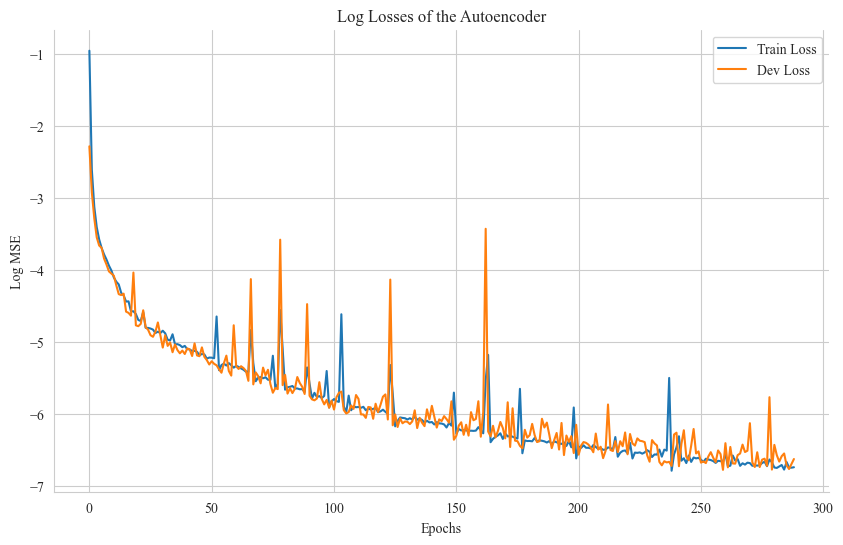

In [70]:
# Reloading the losses
losses = joblib.load(os.path.join(autoencoder_path, "losses.pkl"))

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the training and dev losses
plt.plot(np.log(losses['loss']), label="Train Loss")
plt.plot(np.log(losses['val_loss']), label="Dev Loss")

# Plot settings
plt.xlabel("Epochs")
plt.ylabel("Log MSE")
plt.title("Log Losses of the Autoencoder")
plt.legend()
sns.despine()

# Showing the plot
plt.show()

#### Tuning the Model on the Dev Set

In [71]:
# Reconstruction loss for each sample
sample_recon_loss = lambda label, pred: tf.reduce_mean(tf.square(tf.subtract(label, pred)), axis=1).numpy()

In [72]:
# Raw reconstruction loss for each sample
ae_recon_dev = sample_recon_loss(X_dev, ae.predict(X_dev, verbose=0))

# Tuning the threshold
ae_threshold, _ = tune_model_to(label=y_dev, raw_prediction=ae_recon_dev, thresholds=np.arange(0, 0.05, 0.0001), metric=f1_score)

# Getting the predictions
ae_pred_dev = (ae_recon_dev > ae_threshold).astype(int)

In [73]:
# Evaluating the model
ae_dev_eval = classifier_metrics(y_dev, ae_pred_dev, ae_recon_dev)

# Displaying the results
ae_dev_eval

{'Accuracy': 0.8604651162790697,
 'F1': 0.8592483419307296,
 'Precision': 0.8666997026759168,
 'Recall': 0.8519240136385777,
 'AUROC': 0.9317658978866704,
 'AUPRC': 0.9378135155098394}

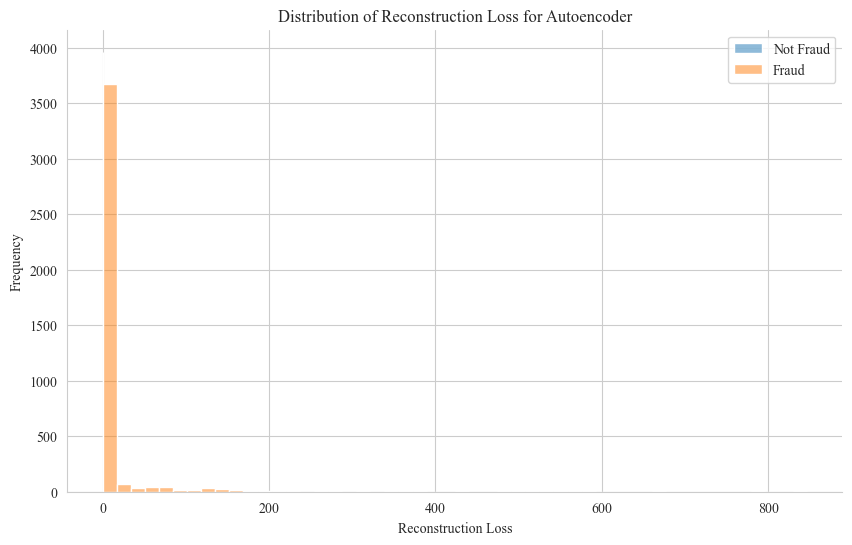

In [74]:
# Distribution of the Reconstruction Loss
plot_dist(ae_recon_dev[y_dev == 0], ae_recon_dev[y_dev == 1], 50, 
          "Reconstruction Loss", "Autoencoder")

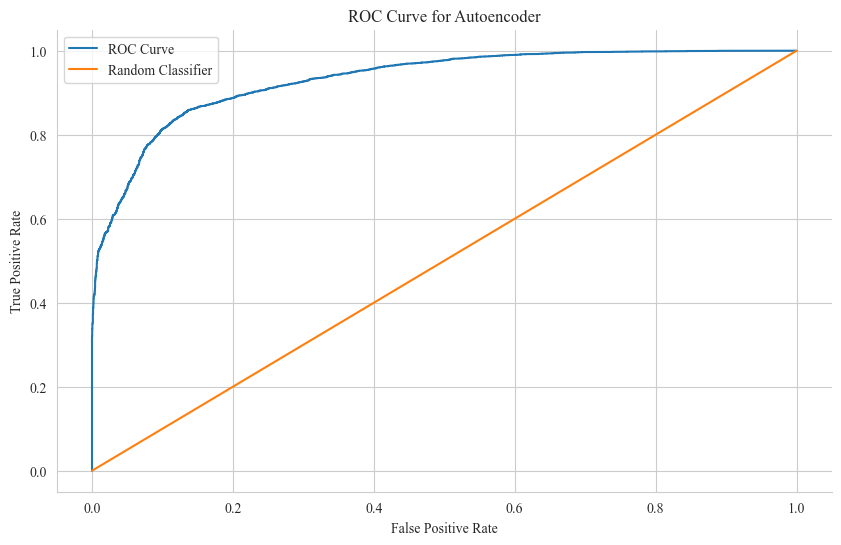

In [75]:
# Plotting the ROC curve
plot_roc_curve(y_dev, ae_recon_dev, "Autoencoder")

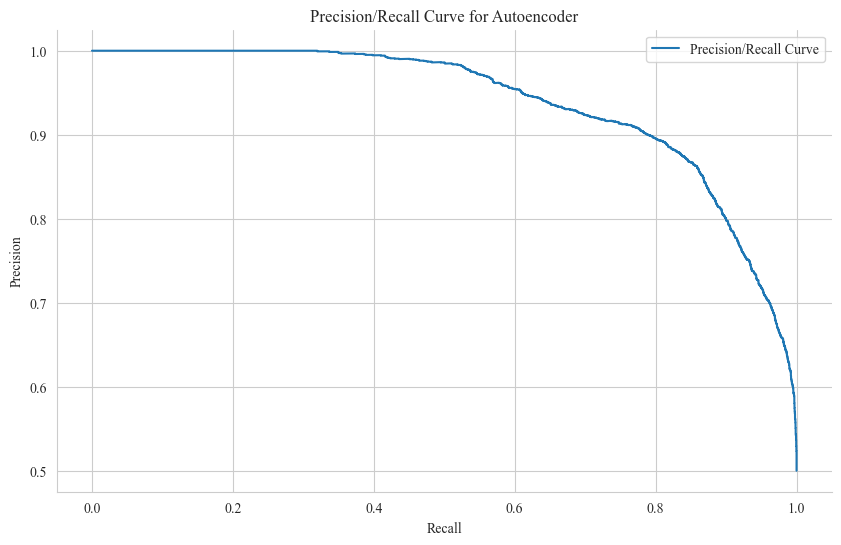

In [76]:
# Plotting the precision-recall curve
plot_precision_recall_curve(y_dev, ae_recon_dev, "Autoencoder")

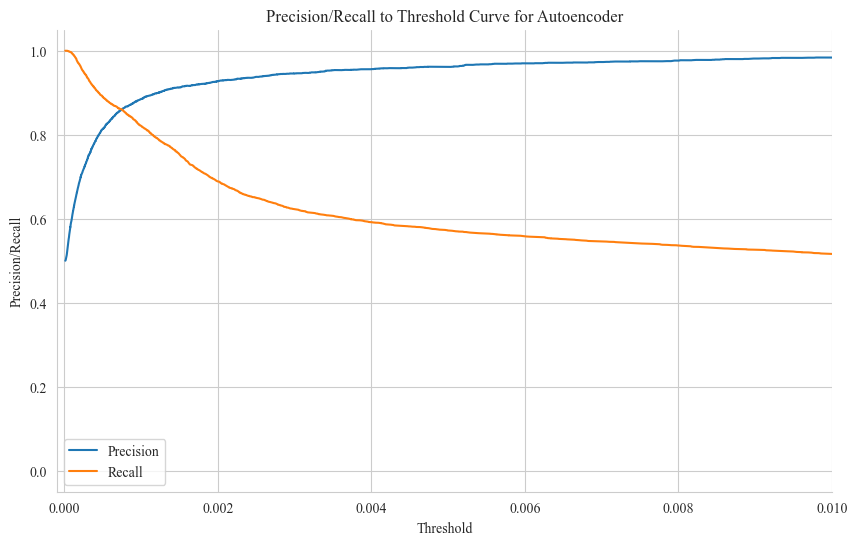

In [77]:
# Plotting the precision/recall to threshold curve
plot_pr_threshold(y_dev, ae_recon_dev, "Autoencoder", xlim=(-0.0001, 0.01))

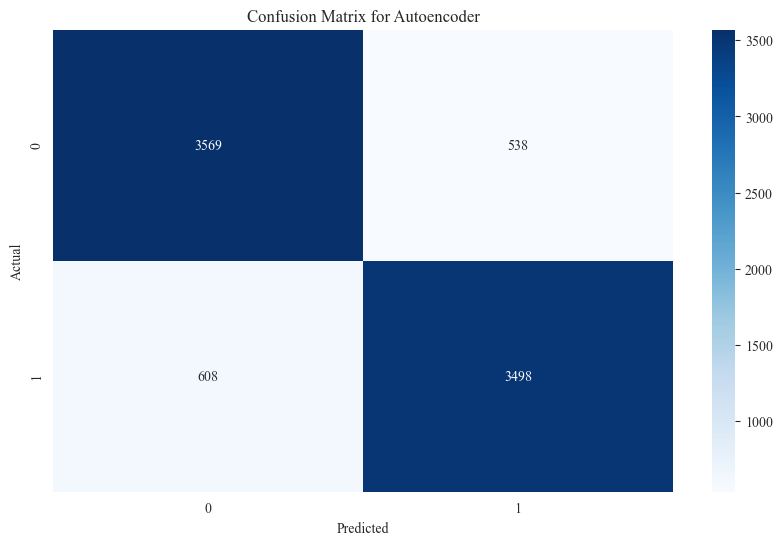

In [78]:
# Plotting the confusion matrix
plot_confusion_matrix(y_dev, ae_pred_dev, "Autoencoder")

## Comparison of Models

### Metric Comparison

In [79]:
# Comparison of the thresholds
km_threshold, gmm_threshold, ae_threshold

(3.13, 16.400000000000002, 0.0008)

In [80]:
# Creating a dataframe with the metrics for the dev set
dev_metrics = pd.DataFrame([km_dev_eval, gmm_dev_eval, ae_dev_eval], index=["K-Means", "Gausian Mixture", "Autoencoder"])

# Displaying the metrics
dev_metrics * 100

,Accuracy,F1,Precision,Recall,AUROC,AUPRC
K-Means,84.561,84.434,85.124,83.755,89.005,91.199
Gausian Mixture,85.158,85.096,85.441,84.754,90.734,92.073
Autoencoder,86.047,85.925,86.670,85.192,93.177,93.781


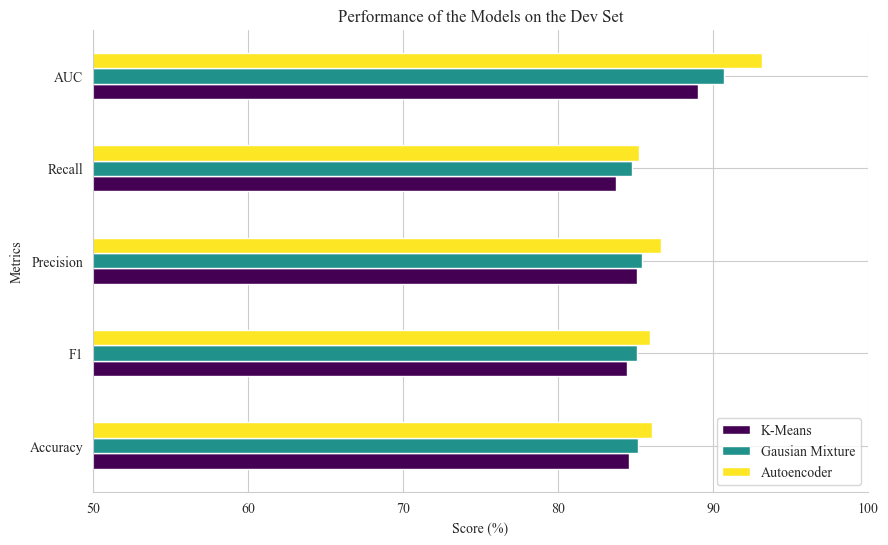

In [81]:
# Plotting the performance of the models aggregated by metric
(dev_metrics.drop('AUPRC', axis=1).rename({'AUROC':'AUC'}, axis=1).T * 100).\
    plot(kind="barh", rot=0, figsize=(10, 6), cmap="viridis")

# Plot settings
plt.ylabel("Metrics")
plt.xlabel("Score (%)")
plt.title("Performance of the Models on the Dev Set")
plt.xlim(50, 100)
sns.despine()

# Showing the plot
plt.show()

### ROC and Precision-Recall Curve

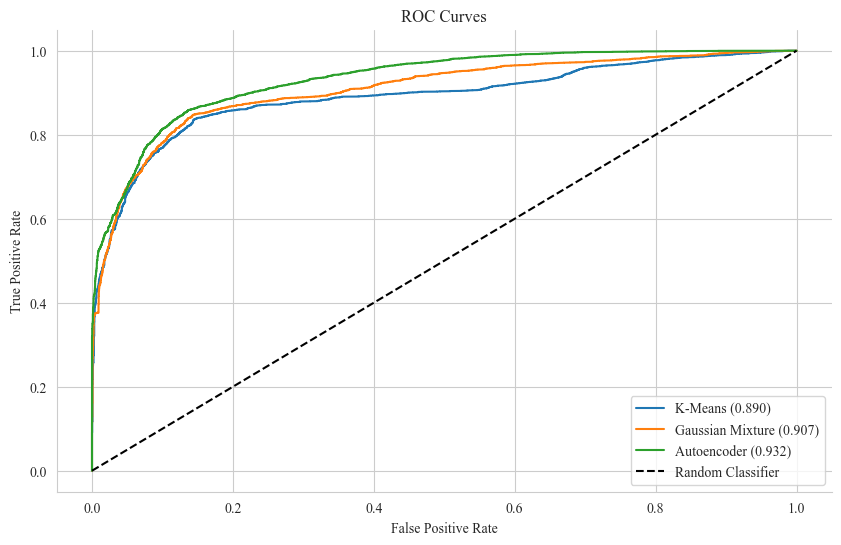

In [82]:
# Calculating the ROC for each model
fp_rate_km, tp_rate_km, _ = roc_curve(y_dev, km_distance_dev)
fp_rate_gmm, tp_rate_gmm, _ = roc_curve(y_dev, gmm_density_dev)
fp_rate_ae, tp_rate_ae, _ = roc_curve(y_dev, ae_recon_dev)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the ROC curves
plt.plot(fp_rate_km, tp_rate_km, label=f"K-Means ({km_dev_eval['AUROC']:.3f})")
plt.plot(fp_rate_gmm, tp_rate_gmm, label=f"Gaussian Mixture ({gmm_dev_eval['AUROC']:.3f})")
plt.plot(fp_rate_ae, tp_rate_ae, label=f"Autoencoder ({ae_dev_eval['AUROC']:.3f})")
plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="Random Classifier")

# Plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
sns.despine()

# Showing the plot
plt.show()

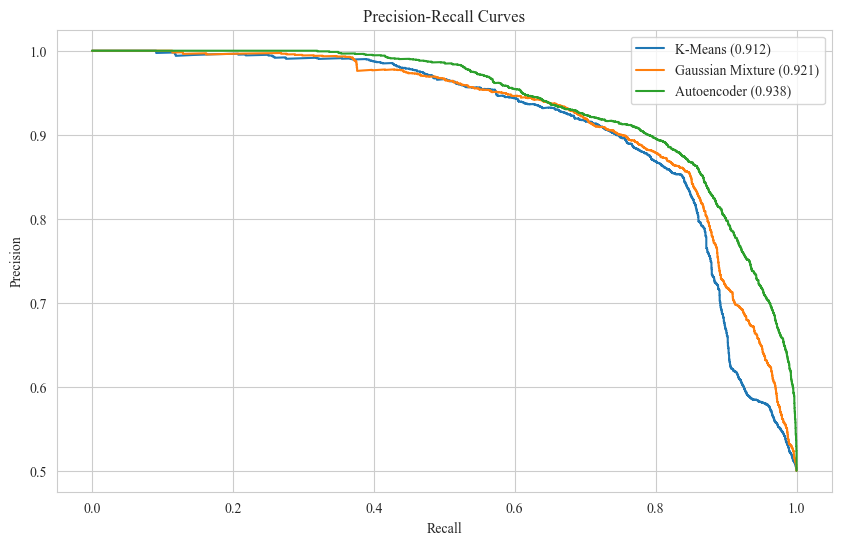

In [83]:
# Calculating the precision-recalls for each model
pr_km, rc_km, _ = precision_recall_curve(y_dev, km_distance_dev)
pr_gmm, rc_gmm, _ = precision_recall_curve(y_dev, gmm_density_dev)
pr_ae, rc_ae, _ = precision_recall_curve(y_dev, ae_recon_dev)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the precision-recall curves
plt.plot(rc_km, pr_km, label=f"K-Means ({km_dev_eval['AUPRC']:.3f})")
plt.plot(rc_gmm, pr_gmm, label=f"Gaussian Mixture ({gmm_dev_eval['AUPRC']:.3f})")
plt.plot(rc_ae, pr_ae, label=f"Autoencoder ({ae_dev_eval['AUPRC']:.3f})")

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()

# Showing the plot
plt.show()

### Using the Best Model on the Test Set

In [84]:
# Evaluating the best model on the test set
ae_recon_test = sample_recon_loss(X_test, ae.predict(X_test, verbose=0))

# Getting the predictions
ae_pred_test = (ae_recon_test > ae_threshold).astype(int)

In [85]:
# Evaluating the model
ae_test_eval = classifier_metrics(y_test, ae_pred_test, ae_recon_test)

# Displaying the results
ae_test_eval

{'Accuracy': 0.8574211615731158,
 'F1': 0.854804711717297,
 'Precision': 0.8708943911066195,
 'Recall': 0.8392987582176772,
 'AUROC': 0.9288302994744458,
 'AUPRC': 0.9340813720480451}

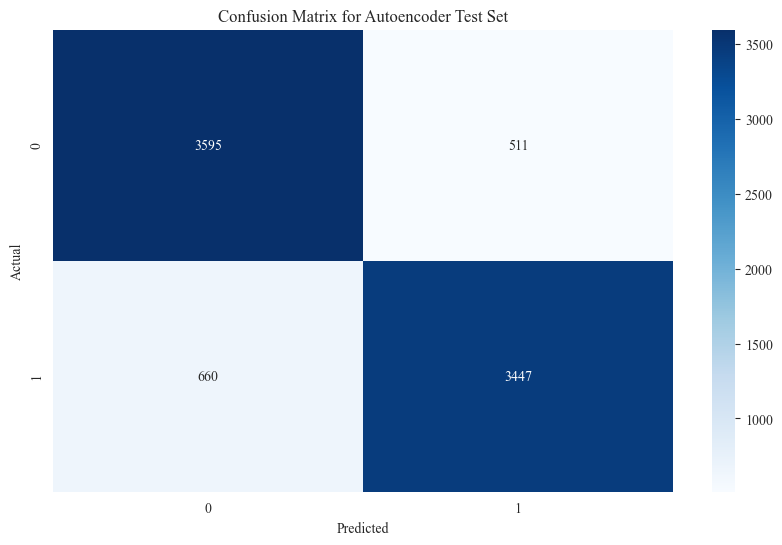

In [86]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, ae_pred_test, "Autoencoder Test Set")